In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import random

In [137]:
data = pd.read_csv('XGBoost筛选的特征_单帆1.csv')
data_val = data.values
data_GDP = data['GDP']
data_gdp = data_GDP.values
random_epsilon = 2000000*np.random.rand(data_gdp.shape[0])
gdp_plus = data_gdp+random_epsilon
gdp_minus = data_gdp-random_epsilon

## 选择你的数据
data['GDP'] = gdp_plus

In [69]:
data1 = data.values

x_data = data1[:,:-1]
y_data = data1[:,-1]
y_max = np.max(y_data)
y_min = np.min(y_data)
y = (y_data-y_min)/(y_max-y_min)

X_train,X_test,y_train,y_test = train_test_split(x_data,y,test_size=0.15,random_state=0)

In [178]:
print(y_max)
print(y_min)

2890000.0
95000.0


In [144]:
import pickle

with open('stacking_model_单.pkl','rb') as f:
    stack_model1 = pickle.load(f)


In [71]:
## 现在对改变之后的GDP进行预测
y_model1_pre = stack_model1.predict(x_data)
y_pre1 = y_model1_pre*(y_max-y_min)+y_min  ##GDP改变之后的价格
y_true = y*(y_max-y_min)+y_min  ##GDP改变之前的价格
print(y_pre1)

[549011.51103456 587324.77530596 355514.02158939 ... 220119.53741611
 518514.77348085 496071.71394756]


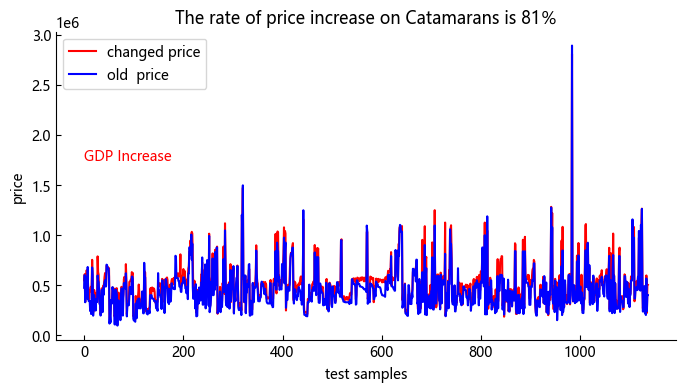

In [183]:
plt.figure(figsize=(8,4),dpi=100)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.rcParams['font.family'] = 'Microsoft YaHei'  # 设置微软雅黑字体
plt.plot(y_pre1,'r',label ='changed price')
plt.plot(y_true,'b-',label = 'old  price')
plt.xlabel('test samples')
plt.ylabel('price')
plt.title('The rate of price increase on Catamarans is 81％')
# 设置坐标轴刻度在内部
plt.tick_params(axis='both', direction='in')
# 添加文字解释
plt.text(0, 1750000, "GDP Increase  ", fontsize=10, color='r')
plt.legend()
plt.savefig('Images/双帆GDP增加情况.png')

In [181]:
num = 0
for i in range(len(y)):
    if y_data[i]<y_pre1[i]:
        num+=1
print(num/len(y))

0.8110720562390158


In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 生成随机数据
# X = np.random.rand(data_gdp.shape[0], 2)
X = np.random.rand(data_gdp.shape[0], 1)
# X[:,0] = [i for i in range(data_gdp.shape[0])]
X[:,0] = data_gdp
# 创建KMeans对象并拟合数据
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

## 可视化
# plt.figure(figsize=(11,6),dpi=100)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.rcParams['font.family'] = 'Microsoft YaHei'  # 设置微软雅黑字体
# # 设置坐标轴刻度在内部
# plt.tick_params(axis='both', direction='in')
# # 绘制原始数据
# plt.scatter(X[:, 0], X[:, 1])

# 获取聚类标签
labels = kmeans.labels_

# 根据聚类标签绘制不同颜色的数据点
# for i in range(max(labels)+1):
#     plt.scatter(X[labels == i, 0], X[labels == i, 1], label='Region {}'.format(i+1))

# # 绘制聚类中心
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=150, marker='^', label='Centroids')

# # 添加图例
# plt.legend(loc='upper left')
# plt.xlabel('Samples index')
# plt.ylabel('GDP')
# # plt.ylim([0 ,140000 ])
# plt.title('GDP data clustering on Catamarans ')
# plt.savefig('Images/GDP聚类图_双帆.png')
# # 显示图形
# plt.show()


In [139]:
new_data = [[49800]]
clf = kmeans.predict(new_data)
print(clf)

[2]


In [140]:
# 获取第2类的所有数据
class_2_data = X[kmeans.labels_ == 2]
print(class_2_data.shape)

(952, 1)


In [141]:
# 获取第2类的所有数据的索引
class_2_indices = np.where(kmeans.labels_ == 2)[0]  ##双帆
# Hongkong_data_2 = data_val[class_2_indices] ##最终获得的双帆的数据

Hongkong_data_1 = data_val[class_2_indices] ##最终获得的双帆的数据

# print(Hongkong_data_1)


In [142]:

x_data = Hongkong_data_1[:,:-1]
y_data = Hongkong_data_1[:,-1]
y_max = np.max(y_data)
y_min = np.min(y_data)
y = (y_data-y_min)/(y_max-y_min)

X_train,X_test,y_train,y_test = train_test_split(x_data,y,test_size=0.15,random_state=0)

In [143]:
### 下面重新使用Stacking融合对香港特区的单帆进行预测
from sklearn.ensemble import StackingRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
lgb_model = lgb.LGBMRegressor()
# ('rf', RandomForestRegressor( random_state=42)),
base_regressors = [
                   ('lr', LinearRegression()),
                   ('xg',XGBRegressor()),
                   ('re',GradientBoostingRegressor()),
                   ('lgb',lgb_model)
                   ]
meta_regressor = LinearRegression()
stack_reg = StackingRegressor(estimators=base_regressors, final_estimator=meta_regressor)
stack_reg.fit(X_train, y_train)
# 使用交叉验证计算 R2 分数
scores = cross_val_score(stack_reg, X_train, y_train, cv=20, scoring='r2')

# 打印分数
print(scores)
print("Mean score:", scores.mean())
y_pred = stack_reg.predict(X_test)
y_pr = y_pred*(y_max-y_min)+y_min
mse = mean_squared_error(y_test, y_pred)
## 平均绝对误差
mae = mean_absolute_error(y_test,y_pred) #MAE是预测值与真实值之差的绝对值的平均值。MAE越小，说明预测结果与真实值越接近
# 均方根误差（RMSE）
rmse = np.sqrt(mse)
#  决定系数
r2 = r2_score(y_test, y_pred)

print("MSE:\n", mse)
print("R2 Score:\n", r2)
print('MAE:\n',mae)
print("RMSE:\n", rmse)



[0.78732208 0.86711752 0.74804085 0.72997892 0.76830249 0.83460604
 0.50406484 0.74868012 0.57750034 0.62655697 0.64624279 0.87259472
 0.74006077 0.58749068 0.57880627 0.65849813 0.71313341 0.88353429
 0.75543573 0.869827  ]
Mean score: 0.7248896970858938
MSE:
 0.0022938313208091714
R2 Score:
 0.6167742077837917
MAE:
 0.025408553787183628
RMSE:
 0.04789395912648245


In [145]:
y_tru = y_test*(y_max-y_min)+y_min
# plt.figure(figsize=(11,5),dpi=100)
# plt.grid(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.rcParams['font.family'] = 'Microsoft YaHei'  # 设置微软雅黑字体
# plt.plot(y_pr,'r*',linewidth='1.5',
# label ='predict price')
# plt.plot(y_tru,'y',label = 'true price')
# plt.xlabel('test samples')
# plt.ylabel('price predict')
# plt.title('Catamarans price prediction of Hong Kong ')
# # 设置坐标轴刻度在内部
# plt.tick_params(axis='both', direction='in')
# # 添加文字解释
# plt.text(0, 1000000, "$R_2 score = 0.86$", fontsize=12, color='g')
# plt.legend(loc = 'upper right')
# plt.savefig('Images/香港双帆预测.png')

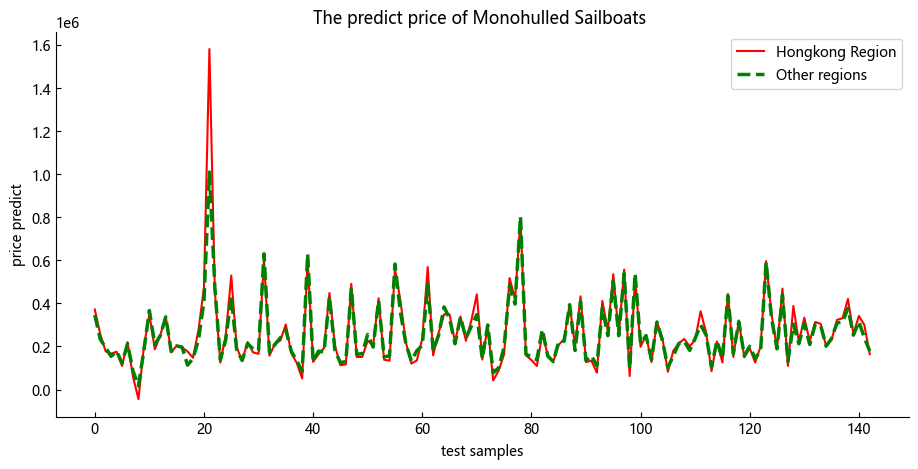

In [148]:
old1 = stack_model1.predict(X_test)
old1 = old1*(y_max-y_min)+y_min
plt.figure(figsize=(11,5),dpi=100)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.rcParams['font.family'] = 'Microsoft YaHei'  # 设置微软雅黑字体
plt.plot(y_pr,'r-',linewidth='1.5',
label ='Hongkong Region')
plt.plot(old1,'g--',linewidth = '2.5',label = 'Other regions')
plt.xlabel('test samples')
plt.ylabel('price predict')
plt.title('The predict price of Monohulled Sailboats ')
# 设置坐标轴刻度在内部
plt.tick_params(axis='both', direction='in')
# 添加文字解释
plt.legend(loc = 'upper right')
plt.savefig('Images/香港特区对单帆价格影响.png')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


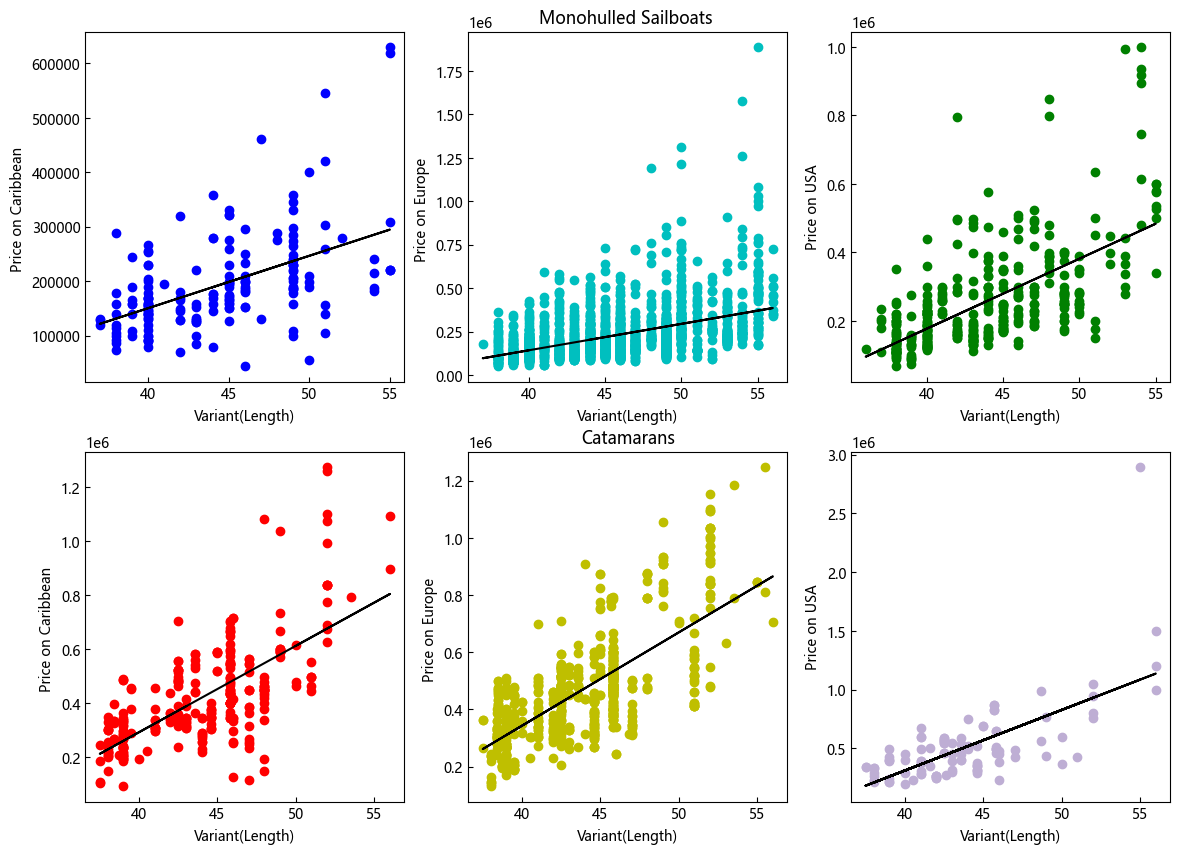

In [196]:
## 制作长度与价格的关系图（不同区域）针对单帆
regions = ['Caribbean','Europe','USA']
data_price_length1 = pd.read_excel('length-price.xlsx')
data_price_length2 = pd.read_excel('Length-price2.xlsx')
values1 = data_price_length1.values
values2 = data_price_length2.values
caribbean_data1 = values2[:301,:]
caribbean_data = values1[:178,:]
Europe_data1 = values2[302:1037,:]
Europe_data = values1[177:1960,:]
Usa_data1 = values2[1037:,:]
Usa_data = values1[1961:,:]
plt.figure(figsize=(14,10),dpi=100)
plt.rcParams['font.family'] = 'Microsoft YaHei'  # 设置微软雅黑字体
# 设置坐标轴刻度在内部
plt.subplot(2,3,1)
plt.tick_params(axis='both', direction='in')
coefficients1 = np.polyfit(caribbean_data[:,0], caribbean_data[:,1], 1)
a1 = coefficients1[0]
b1 = coefficients1[1]
line1 = a1 * caribbean_data[:,0] + b1
plt.scatter(caribbean_data[:,0],caribbean_data[:,1],c='b')
plt.plot(caribbean_data[:,0],line1,c='k')
plt.xlabel('Variant(Length)')
plt.ylabel('Price on Caribbean ')
plt.subplot(2,3,2)
plt.title('Monohulled Sailboats ')
plt.tick_params(axis='both', direction='in')
coefficients2 = np.polyfit(Europe_data[:,0], Europe_data[:,1], 1)
a2 = coefficients2[0]
b2= coefficients2[1]
line2 = a2 * Europe_data[:,0] + b2
plt.scatter(Europe_data[:,0],Europe_data[:,1],c='c')
plt.plot(Europe_data[:,0],line2,c = 'k')
plt.xlabel('Variant(Length)')
plt.ylabel('Price on Europe ')
plt.subplot(2,3,3)
plt.tick_params(axis='both', direction='in')
plt.scatter(Usa_data[:,0],Usa_data[:,1],c='g')
coefficients3 = np.polyfit(Usa_data[:,0], Usa_data[:,1], 1)
a3= coefficients3[0]
b3= coefficients3[1]
line3 = a3 * Usa_data[:,0] + b3
plt.plot(Usa_data[:,0],line3,c= 'k')
plt.xlabel('Variant(Length)')
plt.ylabel('Price on USA')
plt.subplot(2,3,4)
plt.tick_params(axis='both', direction='in')
coefficients4 = np.polyfit(caribbean_data1[:,0], caribbean_data1[:,1], 1)
a4 = coefficients4[0]
b4 = coefficients4[1]
line4 = a4 * caribbean_data1[:,0] + b4
plt.scatter(caribbean_data1[:,0],caribbean_data1[:,1],c='r')
plt.plot(caribbean_data1[:,0],line4,c='k')
plt.xlabel('Variant(Length)')
plt.ylabel('Price on Caribbean ')
plt.subplot(2,3,5)
plt.title('Catamarans')
plt.tick_params(axis='both', direction='in')
coefficients5 = np.polyfit(Europe_data1[:,0], Europe_data1[:,1], 1)
a5 = coefficients5[0]
b5= coefficients5[1]
line5 = a5 * Europe_data1[:,0] + b5
plt.scatter(Europe_data1[:,0],Europe_data1[:,1],c='y')
plt.plot(Europe_data1[:,0],line5,c = 'k')
plt.xlabel('Variant(Length)')
plt.ylabel('Price on Europe ')
plt.subplot(2,3,6)
plt.tick_params(axis='both', direction='in')
plt.scatter(Usa_data1[:,0],Usa_data1[:,1],c=plt.cm.Accent(1))
coefficients6 = np.polyfit(Usa_data1[:,0], Usa_data1[:,1], 1)
a6= coefficients6[0]
b6= coefficients6[1]
line6 = a6 * Usa_data1[:,0] + b6
plt.plot(Usa_data1[:,0],line6,c= 'k')
plt.xlabel('Variant(Length)')
plt.ylabel('Price on USA')
plt.savefig('Images/子图')
plt.show()